# The L2 Ball's View of the L1 Norm

John Mount<br/>
jmount@win-vector.com<br/>
Win Vector LLC<br/>
6-10-2023<br/>

## Abstract


Define $a_{n}$ to be expected value of $\sum_{i=1}^{n} |x_i|$ given $\sum_{i=1}^{n} x_i^2 = 1$ where $x$ is uniformly distributed such. That is: for $x \in \mathbb{R}^{n}$ distributed uniformly on the boundary of the unit ball, what is the expected L1 norm of $x$?

The answer is: $\lim_{n \rightarrow \infty} a_n / \sqrt{n} = \sqrt{2 / \pi}$.

## Deriving the Solution

Let's work up to the answer.


In [1]:
import sympy
from sympy import cos, exp, factorial, gamma, loggamma, pi, sin, sqrt
from IPython.display import display
sympy.init_printing(use_unicode=False, wrap_line=False)
import numpy.random
import numpy as np


In [2]:
rng = numpy.random.default_rng(seed=2023)


We can work out that: $a_{1} = 1$. 

### Solving for $a_2$

Now induct on $n$, and suppose we know $a_{n-1}$.

$\sum_{i=1}^{n-1} x_i^2 = 1 - x_n^2$. So if $x_n = \cos(z)$ then $\sum_{i=1}^{n-1} x_i^2 = \sin(z)^2$.  

By induction $\sum_{i=1}^{n-1} (x_i / \sin(z))^2 = 1$ implies $\text{E}[\sum_{i=1}^{n-1} |x_i / \sin(z)|] = a_{n-1}$. So $\text{E}[\sum_{i=1}^{n-1} |x_i|] = a_{n-1} \sin(z)$.

This gives us:

$$
a_{2} = \int_{\lambda = 0}^{1} (\cos((\pi/2) \lambda) + a_{1} \sin((\pi/2) \lambda)) \text{d}\lambda
$$


In [3]:
a_1 = 1
x = sympy.Symbol('x')
a_2 = sympy.integrate(cos((pi/2) * x) + a_1 * sin((pi/2) * x), (x, 0, 1))
a_2


In [4]:
float(a_2)


We can confirm the values of $a_1$ and $a_2$ empirically.


In [5]:
def l1_example(dim: int):
    """Compute l1-norm of a uniformly selected unit l2-vector"""
    dim = int(dim)
    assert dim >= 1
    v = None
    v_norm_sq = 0
    while v_norm_sq <= 0:
        v = rng.normal(size=dim)
        v_norm_sq = np.dot(v, v)
    v = v / np.sqrt(v_norm_sq)
    return np.sum(np.abs(v))


In [6]:
# get average l1 metric of many unit l2-examples in dimension 1
np.mean([l1_example(1) for r in range(100000)])


In [7]:
# get average l1 metric of many unit l2-examples in dimension 2
np.mean([l1_example(2) for r in range(100000)])


### Solving for $a_n$

For larger $n$ we would expect the following.

$$
a_{n} = \frac{\int_{\lambda = 0}^{1} (\cos((\pi/2) \lambda) + a_{n-1} \sin((\pi/2) \lambda)) \sin((\pi/2) \lambda)^{n-2} \;\text{d}\lambda}{\int_{\lambda = 0}^{1} \sin((\pi/2) \lambda)^{n-2} \;\text{d}\lambda}
$$

The $\sin((\pi/2) \lambda)^{n-2}$ term being the proportion of the $n-1$ sphere volume in each portion of the integral.

Let's try that for $n = 3$.


In [8]:
def next_a(*, n: int, a_previous):
    """Compute a_{n} from a_{n-1}"""
    n = int(n)
    assert n > 1
    return (
        sympy.integrate(
        (cos((pi/2) * x) + a_previous * sin((pi/2) * x)) * sin((pi/2) * x)**n, 
        (x, 0, 1))
        / sympy.integrate(
        sin((pi/2) * x)**n, 
        (x, 0, 1))
    ).expand().simplify()


In [9]:
a_3 = next_a(n=3, a_previous=a_2)

a_3


In [10]:
float(a_3)


And let's confirm that with another simulation.


In [11]:
# get average l1 metric of many unit l2-examples in dimension 3
np.mean([l1_example(3) for r in range(100000)])


And let's try that for $a_4$.


In [12]:
a_4 = next_a(n=4, a_previous=a_3)

a_4


In [13]:
float(a_4)


In [14]:
# get average l1 metric of many unit l2-examples in dimension 4
np.mean([l1_example(4) for r in range(100000)])


Let's try a larger $n$.


In [15]:
def calc_a_n(n: int):
    """Calculate a_n by iterating next_a()"""
    n = int(n)
    assert n >= 1
    if n <= 1:
        return 1
    a_n = 1
    for i in range(2, n+1):
        a_n = next_a(n=i, a_previous=a_n)
    return a_n


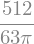

In [16]:
a_10 = calc_a_n(10)

a_10


In [17]:
float(a_10)


In [18]:
# get average l1 metric of many unit l2-examples in dimension 10
np.mean([l1_example(10) for r in range(100000)])


### Writing a Recurrence

With a recurrence relating $a_{n}$ to $a_{n-1}$ we would expect to be able to work out the asymptotic behavior of $a_{n}$. Let's try to eliminate the integrals and pursue that path.

Integration by parts would let us derive the following two identities for positive integer $k$.

$$
s(k) 
 := \int_{\lambda = 0}^{1} \sin((\pi/2) \lambda)^{k} \text{d}\lambda 
 = \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1) \sqrt{\pi}}
$$

$$
c(k) 
 := \int_{\lambda = 0}^{1} \cos((\pi/2) \lambda) \sin((\pi/2) \lambda)^{k} \text{d}\lambda 
 = \frac{2}{(k+1) \pi}
$$

So our recurrence is then:

$$
a_{n} = (c(n-2) + a_{n-1} s(n-1)) / s(n-2)
$$


In [19]:
def gamma_k_plus_half(k: int):
    """Compute gamma(k + 1/2) for non-negative integer k"""
    k = int(k)
    assert k >= 0
    return sqrt(pi) * int(factorial(2 * k)) / (2**(2*k) * int(factorial(k)))

def s(k: int):
    """Compute s() integral."""
    k = int(k)
    assert k >= 1
    if (k & 1) == 0:
        # even
        return gamma_k_plus_half(k/2) / (int(factorial(k/2)) * sqrt(pi))
    else:
        # odd
        return int(factorial((k-1)/2)) / (gamma_k_plus_half((k+1)/2) * sqrt(pi))

def c(k):
    """Compute c() integral"""
    k = int(k)
    assert k >= 1
    return 2 / ((k + 1) * pi)

def next_a_by_soln(*, n: int, a_previous):
    """Compute a_{n} from a_{n-1} using recurrence formula"""
    n = int(n)
    assert n >= 1
    return (
        (c(n-2) + a_previous * s(n-1)) / s(n-2)
        ).expand().simplify()


We can confirm we have the right functions and recurrence.


In [20]:
next_a_by_soln(n=3, a_previous=a_2)


In [21]:
a_3


In [22]:
next_a_by_soln(n=4, a_previous=a_3)


In [23]:
a_4


We can wrap all of this in a function to get $a_n$ for larger $n$.


In [24]:
soln_cache = {
    1: a_1,
    2: a_2,
}

def calc_a_n_by_soln(n: int):
    """Calculate a_n by advancing next_a_by_soln() (cached)."""
    n = int(n)
    assert n >= 1
    try:
        return soln_cache[n]
    except KeyError:
        pass
    i = np.max(list(soln_cache.keys()))
    a_n = soln_cache[i]
    while i < n:
        i = i + 1
        a_n = next_a_by_soln(n=i, a_previous=a_n)
        soln_cache[i] = a_n
    return a_n


In [25]:
calc_a_n_by_soln(4)


In [26]:
a_4


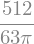

In [27]:
calc_a_n_by_soln(10)


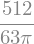

In [28]:
a_10


#### Other things to check

With the recurrence form, we likely have enough tools to check, with some additional work, that the $0 < a_{n} / \sqrt{n} < a_{n-1}  / \sqrt{n-1} < 1$ for all $n$. This sort of monotone behavior in a closed interval makes for a very well behaved sequence and limits

In [29]:
# spot check
assert (float(a_2) / sqrt(2)) < (float(a_1) / sqrt(1))
assert (float(a_3) / sqrt(3)) < (float(a_2) / sqrt(2))
assert (float(a_4) / sqrt(4)) < (float(a_3) / sqrt(3))

## Solving for the Limiting Case

If the $c()$ and $s()$ functions are approaching a limit, then we would expect to find the limit of the $a_n$ as a solution to:

$$
a \approx (c(n-2) + a s(n-1)) / s(n-2)
$$

With some algebra we expect.

$$
a \approx (s(n-2) - s(n-1)) / c(n-2)
$$

And we can inspect the above for the asymptotic behavior of $a_{n}$.

We conjecture that:

$$
\lim_{n \rightarrow \infty} s(n) - s(n+1) = 1/(n^{3/2} \sqrt{2 \pi})
$$

If this is so, we can write:

$$
\lim_{n \rightarrow \infty} a_{n} / \sqrt{n} = \sqrt{2 / \pi}
$$

establishing the orignal claim.

We can check that a large that $a_{n} / \sqrt{n}$ is near $\sqrt{2 / \pi}$ for large $n$.


In [30]:
float(sqrt(2 / pi))


In [31]:
float(calc_a_n_by_soln(1000) / 1000**(1/2))


In [32]:
float(calc_a_n_by_soln(2000) / 2000**(1/2))


## Confirming Our Assumption

What remains is to confirm $\lim_{n \rightarrow \infty} s(n) - s(n+1) = 1/(n^{3/2} \sqrt{2 \pi})$. A quick check shows this is plausible.


In [33]:
float(s(10000) - s(10000 + 1))


In [34]:
float(1 / (10000**(3/2) * sqrt(2 * pi)))


Define the following function $z(k) = \frac{\Gamma(k/2 + 1/2)}{\Gamma(k/2 + 1)}$.


In [35]:
def z(n: int):
    """Simpler fn to stand in for s()"""
    n = int(n)
    assert n > 0
    return exp(loggamma(n/2 + 1/2) - loggamma(n/2 + 1))


The idea is $z(x) = \sqrt{\pi} s(x)$, and is a bit simpler to work with. 

Let's confirm that.


In [36]:
float(z(1000))


In [37]:
float(sqrt(pi) * s(1000))


So the remaining claim to check is that 

$$
\lim_{n \rightarrow \infty} z(n) - z(n+1) = 1/(n^{3/2} \sqrt{2})
$$

First, a quick numeric confirm.


In [38]:
z(100000) - z(100000 + 1)


In [39]:
1/(100000**(3/2) * sqrt(2.0))


To complete our proof we want to show for large $n$ we have:

$$
\frac{\Gamma(n/2 + 1/2)}{\Gamma(n/2 + 1)} - \frac{\Gamma((n+1)/2 + 1/2)}{\Gamma((n+1)/2 + 1)} \approx 1/(n^{3/2} \sqrt{2}) .
$$

Likely this can be got by expanding the $\Gamma()$ functions using the classic $x \Gamma(x) = \Gamma(x+1)$ identity, but that will take some time.

## Conclusion

We have mostly completed showing $\lim_{n \rightarrow \infty} a_n / \sqrt{n} = \sqrt{2 / \pi}$. Or, in high dimensions the typical L2 norm-1 vector has an expected L1 norm of about $\sqrt{2 n / \pi}$.

It is neat that there is a simple large scale or limiting behavior.
